<a href="https://colab.research.google.com/github/syphaxAouadene/Cours_programmation_concurrente/blob/main/my_first_CNN_for_handwritten_digit_classification_version_7_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN from scratch to classify handwritten digit using only Numpy
### Here in this notebook i develloped my first CNN from scratch using Numpy,
### at this point my code is not perfect yet
### you can design an architecture that contains convolution, pooling, flatten, fcl
### but there is conditions to respect : 
### you can either choose 0 convolution or 1 only convolution layer (you can't choose more than one, because i didn't complete the backpropagation through the others convolutions layers)
### if you choose one convolution, then you can choose any number of pooling layers and any numbers of fcl layers
### if you choose zero convolution then you can execute pooling and fcl as many times you want
### if we choose to omit convultion, and pooling, then my CNN can be seen like A classic neural network with many hidden lyers you want, and for instance you can do an architecture like this : input_image--->flatten()--->fcl1--->fcl2--->...etc
### And of course you can choose numbers of epochs, and value of learning rate
## as reminder : this code is not yet perfect, wait for the next version of my code


In [ ]:
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
import json
import matplotlib.pyplot as plt
%pylab inline
import os

from mlxtend.data import loadlocal_mnist
import platform

Populating the interactive namespace from numpy and matplotlib


C:\Users\Utilisateur\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['flatten', 'indices', 'tanh']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from scipy import signal
def convolution(img, f):
    """
    this convolution function is not develloped by me, it is taken from the module 'scipy' because it is very fast
    in fact, i devellopped my own function(look below this function), but it's not very fast like scipy.signal.convolve2d()
    that's why i prefer to use this built-in function rather than use my own function
    
    """
    return signal.convolve2d(img, f, mode='valid')




# def convolution(img, f):
#     result = np.zeros((img.shape[0] - f.shape[0] + 1, img.shape[1] - f.shape[1] + 1))
#     for i in range(result.shape[0]):
#         for j in range(result.shape[1]):
#             imaget = img[i:f.shape[0]+i, j:f.shape[1]+j]
#             multi = multiplication(imaget, f)
#             result[i, j] = multi
#     return result



def max_pooling(convolved_map, size_of_pooling_kernel, stride):
#     result_of_pooling has to have shape = ((input_width - kernel_width + 2*padding)/stride) + 1
    result = np.zeros((int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1, int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1))
  
    dP_dC = np.zeros(convolved_map.shape, dtype=np.float64)
    for i in range(0, result.shape[0]):
        for j in range(0, result.shape[1]):
            imaget = convolved_map[stride*i:size_of_pooling_kernel+stride*i, stride*j:size_of_pooling_kernel+stride*j]
            max_indices = np.unravel_index(np.argmax(imaget), imaget.shape)
            max_imaget = imaget[max_indices[0]][max_indices[1]]
            result[i, j] = max_imaget
            dP_dC[stride * i + max_indices[0], stride * j + max_indices[1]] = 1 
    return result, dP_dC


def mean_pooling(convolved_map, size_of_pooling_kernel, stride):
    #     result_of_pooling has to have shape = ((input_width - kernel_width) + 2*padding/stride) + 1
    result = np.zeros((int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1, int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1))
    for i in range(0, result.shape[0], stride):
        for j in range(0, result.shape[1], stride):
            imaget = convolved_map[i:size_of_pooling_kernel+i, j:size_of_pooling_kernel+j]
            result[i, j] = np.mean(imaget)
    return result
    
    
def min_pooling(convolved_map, size_of_pooling_kernel, stride):
    #     result_of_pooling has to have shape = ((input_width - kernel_width) + 2*padding/stride) + 1
    result = np.zeros((int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1, int((convolved_map.shape[0]-size_of_pooling_kernel)/stride)+1))
    for i in range(0, result.shape[0], stride):
        for j in range(0, result.shape[1], stride):
            imaget = convolved_map[i:size_of_pooling_kernel+i, j:size_of_pooling_kernel+j]
            result[i, j] = np.min(imaget)
    return result


def initialize_filter(filter_width, filter_height):
    """
    cette fonction s'occupe de l'initialisation d'un filtre aléatoirement selon la distribution normale
    """
    return np.random.randn(filter_width, filter_height)


def show_image(img):
    plt.imshow(img, cmap=plt.cm.binary)
    plt.show()
    
    
def show_multiple_images(images, nbr_of_images=5):
    for img in images[:nbr_of_images]:
        show_image(img)
        time.sleep(1)
        clear_output(wait=True)

In [ ]:
def unflatten(vector, pooled_layer):
    pooled_layer = np.array(pooled_layer)
    vector = np.array(vector)
    vector = vector.reshape(pooled_layer.shape)
    return vector


def ReLU(layer):
    return layer * (layer > 0)


def d_ReLU(layer):
    return 1. * (layer > 0)


def tanh(layer):
    r = (np.exp(layer)-np.exp(-1*layer))/(np.exp(layer)+np.exp(-1*layer))   
    return np.array(r)


def d_tanh(layer):
    return 1 - tanh(layer) * tanh(layer)


def segmoid(layer):
    return np.exp(layer)/(1 + np.exp(layer))


def d_segmoid(vector):
    """
    cette fontion prend un vector en entrée et retourne la dérivée de segmoid par rapport a ce vector
    """
    return segmoid(vector) * (1 - segmoid(vector))


def softmax(x):
    maxi = np.max(x)
    return np.exp(x-maxi)/np.sum(np.exp(x-maxi))


def categoricalCrossEntropy(generated_values, target_values):
    generated_values = [[1.0e-100] if r[0]==0.0 else r for r in generated_values]
    somme = 0
    for i in range(len(generated_values)):
        somme = somme + target_values[i] * np.log(generated_values[i])
    return (-1) * somme 


def normelize(img):
    return (img/255) - 0.5


def flatten(img):
    img = np.array(img) 
    return img.flatten()


def one_hot(y):
    return np.eye(10)[y].reshape(10, 1)


def update_W_and_B(W, dL_dW, B, dL_dB, lr):
    """
    this function update the weights and Biais of myNetwork
    arguments : 
    - W : it is a list that contains each Weight vector ([W1, W2, ...])
    - dL_dW : derivatives of loss with respect to Weights (it is a list that contains Weights derivatives vectors [dL_dW1, dL_dW2, ...])
    - B : it is a list that contains each Biais vector ([B1, B2, ...])
    - dL_dB : derivatives of loss with respect to Biais (it is a list that contains Biais derivatives vectors [dL_dB1, dL_dB2, ...])
    - lr : learning rate (real number)
    """
    new_W = []
    new_B = []
    
    for w, dw in zip(W, dL_dW):
        try:
            w = np.array(w) - lr * np.array(dw)
        except:
            w = None
        
        new_W.append(w)
    for b, db in zip(B, dL_dB):
        try:
            b = np.array(b) - lr * np.array(db)
        except:
            b = None
        
        new_B.append(b)
        
    return new_W, new_B


def compute_accuracy(my_cnn, x_val, y_val, W, B):
    '''
        This function does a forward pass of x_validation, then checks if the indices
        of the maximum value in the output equals the indices in the label
        y. Then it sums over each prediction and calculates the accuracy.
    '''
    predictions = []

    for x, y in zip(x_val, y_val):
        Y = one_hot(y)
        # forward-propagation
        Z, A, dP_dC = forward_propagation([x], my_cnn, W, B)
        output = A[-1]
        pred = np.argmax(output)
        predictions.append(pred == np.argmax(Y))

    return np.mean(predictions)


def show_accuracies(my_cnn, train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B):
    """
    this function compute accuracy for each train-set, validation-set, and test-set
    then print them all.
    arguments : train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B
    """
    train_accuracy = compute_accuracy(my_cnn, train_images, train_labels, W, B)
    val_accuracy = compute_accuracy(my_cnn, val_images, val_labels, W, B)
    test_accuracy = compute_accuracy(my_cnn, test_images, test_labels, W, B)
    print("Accuracies :\n\
    - train accuracy = {} %\n\
    - val accuracy = {} %\n\
    - test accuracy = {} %".format(train_accuracy*100, val_accuracy*100, test_accuracy*100))


# Upload data, normelize it, then shuffle it and finaly split it 

In [ ]:
images_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/train-images.idx3-ubyte'
labels_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/train-labels.idx1-ubyte'
test_images_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/test-images.idx3-ubyte'
test_labels_path = '/content/drive/MyDrive/Colab Notebooks/mnist_data/test-labels.idx1-ubyte'
test_images, test_labels = loadlocal_mnist(test_images_path, test_labels_path)
train_images, train_labels = loadlocal_mnist(images_path, labels_path)

# group all the images in one list
# then normelize all the images
images = np.concatenate([train_images, test_images])
labels = np.concatenate([train_labels, test_labels])
images = normelize(images)

# shuffle all the images and all labels randomly
random.seed(12)
indices = np.arange(len(labels))
np.random.shuffle(indices)
labels = labels[indices]
images = images[indices]

# change shape of the images
images = images.reshape(len(images), 28, 28)

# split the data into train, validation and test 
train_images, val_images, test_images = images[:60000], images[60000:65000], images[65000:]
train_labels, val_labels, test_labels = labels[:60000], labels[60000:65000], labels[65000:]

# Learning  ------>  GO FOR LAUNCH !

In [ ]:
def input_layer(dict):
    dict['type_of_layer'] = 'input'
    return dict

def convolution_layer(dict):
    dict['type_of_layer'] = 'convolution'
    return dict

def pooling_layer(dict):
    dict['type_of_layer'] = 'pooling'
    return dict

def flatten_layer():
    dict = {'type_of_layer': 'flatten'}
    return dict

def fcl(dict):
    dict['type_of_layer'] = 'fcl'
    return dict

In [ ]:
my_cnn = [input_layer({
              'width_image': 28,
              'height_image': 28,
              'nbr_channels': 1   # 1 --> means gray scale, and 3 --> means rgb
              }
          ),
          convolution_layer({
              'nbr_of_kernels':12, 
              'kernel_size':5, 
              'padding':0, 
              'stride':1, 
              'type_of_activation':'relu'
              }
          ), 
          pooling_layer({
              'type_of_pooling' : 'MAX_POOLING',
              'kernel_size' : 2,
              'stride' : 2
              } 
          ),
          # convolution_layer({
          #     'nbr_of_kernels':6, 
          #     'kernel_size':5, 
          #     'padding':0, 
          #     'stride':1, 
          #     'type_of_activation':'relu'
          #     }
          # ), 
          # pooling_layer({
          #     'type_of_pooling' : 'MAX_POOLING',
          #     'kernel_size' : 5,
          #     'stride' : 2
          #     } 
          # ),
          flatten_layer(),
#           fcl({
#               'nbr_of_neurons' : 100, # 20 neurons in hidden layer
#               'type_of_activation' : 'tanh', # 'tanh' will be the activation function in the hidden layer, and 'softmax' in the last layer
#               'learning_rate' : 0.001
#                 }
#           ),
          fcl({
              'nbr_of_neurons' : 10, # nbr of neurons in output_layer layer
              'type_of_activation' : 'softmax', # 'tanh' will be the activation function in the hidden layer, and 'softmax' in the last layer
              'learning_rate' : 0.001
          }
          )
          ]
my_cnn

[{'width_image': 28,
  'height_image': 28,
  'nbr_channels': 1,
  'type_of_layer': 'input'},
 {'nbr_of_kernels': 12,
  'kernel_size': 5,
  'padding': 0,
  'stride': 1,
  'type_of_activation': 'relu',
  'type_of_layer': 'convolution'},
 {'type_of_pooling': 'MAX_POOLING',
  'kernel_size': 2,
  'stride': 2,
  'type_of_layer': 'pooling'},
 {'type_of_layer': 'flatten'},
 {'nbr_of_neurons': 10,
  'type_of_activation': 'softmax',
  'learning_rate': 0.001,
  'type_of_layer': 'fcl'}]

In [ ]:
def forward_propagation(img, my_cnn, W, B):
    my_cnn_architecture = [my_cnn[layer]['type_of_layer'] for layer in range(len(my_cnn))]
    switcher = {
        'convolution': convolution_operation,
        'pooling': pooling_operation,
        'flatten': flatten_operation,
        'fcl' : fcl_operation
    }
    # Get the function from switcher dictionary
    operation_types = [switcher.get(type_of_layer, lambda: "Invalid type_of_activation_function") for type_of_layer in my_cnn_architecture]
    Z, A = [img], [img]
    dP_dC = []
    for i in range(1, len(my_cnn)):
        z, a, dp_dc = operation_types[i](my_cnn[i], A, W, B, i)
        Z.append(z)
        A.append(a)
        if dp_dc != None:
            dP_dC = dp_dc
    return Z, A, dP_dC


def convolution_operation(layer, A, W, B, layer_num):
    previous_layer = A[-1]
    nbr_filters = layer['nbr_of_kernels']
    size_filter = layer['kernel_size']
    convolved_layer = []
    filters = W[layer_num]
    biais = B[layer_num]
    z = []
    for i in range(len(filters)):
        somme = 0
        for feature_map in previous_layer:
            somme = somme + convolution(feature_map, filters[i])
        somme = somme + biais[i]
        z.append(somme)
        convolved_layer.append(ReLU(somme))
    return z, convolved_layer, None


def pooling_operation(layer, A, W, B, layer_num):
    """
    convolved_layer : is a list that contains each convolved_map from previous_layer
    type_of_pooling : should be either 'MAX_POOLING' or 'MEAN_POOLING' or 'MIN_POOLING'
    size_of_pooling_kernel : is an integer that represents the shape of kernel 
                            (if size_of_pooling_kernel=2 then shape_kernel=(2, 2))
    this function return a list that contains each pooled_map
    """
    previous_layer = A[-1]
    type_of_pooling = layer['type_of_pooling']
    size_of_pooling_kernel = layer['kernel_size']
    stride = layer['stride']
    pooled_layer = []
    switcher = {
        'MAX_POOLING': max_pooling,
        'MEAN_POOLING': mean_pooling,
        'MIN_POOLING': min_pooling
    }
    # Get the function from switcher dictionary
    pooling_operation = switcher.get(type_of_pooling, lambda: "Invalid type_of_pooling !")
    # Execute the function
    dP_dC = []
    for mapp in previous_layer:
        pooled_map, dp_dc = pooling_operation(mapp, size_of_pooling_kernel, stride)
        pooled_layer.append(pooled_map)
        dP_dC.append(dp_dc)
    return pooled_layer, pooled_layer, dP_dC


def flatten_operation(layer, A, W, B, layer_num):
    a = flatten(A[-1])
    a = a.reshape(len(a), 1)   
    return a, a, None


def fcl_operation(layer, A, Weights, B, layer_num):
    global W
    global compteur
    compteur += 1
    input_fcl = A[-1]
    if compteur == 1:
        weights_fcl = np.random.randn(layer['nbr_of_neurons'], len(input_fcl))
        W[layer_num] = weights_fcl
    else:
        weights_fcl = W[layer_num]
    biais_fcl = B[layer_num]
    type_of_activation = layer['type_of_activation'].lower()
    switcher = {
        'relu': ReLU,
        'tanh': tanh,
        'segmoid': segmoid,
        'softmax': softmax
    }
    # Get the function from switcher dictionary
    activation_type = switcher.get(type_of_activation, lambda: "Invalid type_of_activation_function, please choose either 'ReLU' or 'tanh' or 'segmoid' or 'softmax' !")
    
    output_fcl = np.dot(weights_fcl, input_fcl) + biais_fcl
    output = activation_type(output_fcl)
    return output_fcl, output, None

In [ ]:
def input_init_W_and_B(my_cnn, num_layer):
    w, b = None, None
    return w, b


def convolution_init_W_and_B(my_cnn, num_layer):
    nbr_filters = my_cnn[num_layer]['nbr_of_kernels']
    size_kernel = my_cnn[num_layer]['kernel_size']
    w = [initialize_filter(size_kernel, size_kernel) for i in range(nbr_filters)]
    b = initialize_filter(nbr_filters, 1)
    return np.array(w), np.array(b)


def pooling_init_W_and_B(my_cnn, num_layer):
    w, b = None, None
    return w, b


def flatten_init_W_and_B(my_cnn, num_layer):
    w, b = None, None
    return w, b


def fcl_init_W_and_B(my_cnn, num_layer):
    global compteur_init # cette variable m'aide à repérer si on est au niveau de la premiere couche fcl ou dans une autre couche fcl
    nbr_neurons = my_cnn[num_layer]['nbr_of_neurons']
    if compteur_init == 0: # on est au niveau de fcl 1 --> sa veut dire qu'on peut pas initialiser notre matrice de poids, car on connait pas la dimension de vecteur issu de la couche précédente 'flatten'
        w = None
        compteur_init += 1
    else : 
        nbr_neurons_previous_layer = my_cnn[num_layer - 1]['nbr_of_neurons']
        w = np.random.randn(nbr_neurons, nbr_neurons_previous_layer)
    
    b = initialize_filter(nbr_neurons, 1)
    return w, np.array(b)


def initialization(my_cnn):
    my_cnn_architecture = [my_cnn[layer]['type_of_layer'] for layer in range(len(my_cnn))]
    switcher = {
        'input': input_init_W_and_B,
        'convolution': convolution_init_W_and_B,
        'pooling': pooling_init_W_and_B,
        'flatten': flatten_init_W_and_B,
        'fcl' : fcl_init_W_and_B
    }
    # Get the function from switcher dictionary
    operation_types = [switcher.get(type_of_layer, lambda: "Invalid type_of_activation_function") for type_of_layer in my_cnn_architecture]
    W, B = [], []
    for i in range(len(my_cnn)):
        w, b = operation_types[i](my_cnn, i)
        W.append(w)
        B.append(b)
    
    return np.array(W), np.array(B)



In [ ]:
def backpro_input(my_cnn, dL_dZ, W, Z, A, num_layer, dP_dC):
    return None, None, None


def backpro_convolution(my_cnn, dL_dZ, W, Z, A, num_layer, dP_dC):
    dl_dz = d_ReLU(np.array(Z[num_layer])) * dL_dZ[-1]
    dL_dF = []
    dL_dX = []
    
    dL_dB = [np.sum(t) for t in dl_dz]
    for mapp in A[num_layer - 1]:
        X = np.array(mapp)
        for dz in dl_dz:
            dL_dF.append(convolution(X, dz))
        
    dL_dB = np.array(dL_dB)
    dL_dB = dL_dB.reshape((dL_dB.shape[0], 1))
    return dL_dF, dL_dB, dL_dX


def backpro_pooling(my_cnn, dL_dZ, W, Z, A, num_layer, dP_dC):
    size_of_pooling_kernel = my_cnn[num_layer]['kernel_size']
    stride = my_cnn[num_layer]['stride']
    dl_dz = np.array(dL_dZ[-1]) 
    dp_dc = np.array(dP_dC) 
    result = []
    for dp, dz in zip(dp_dc, dl_dz):
        b = np.zeros(dp.shape)
        i = 0
        while i in range(dz.shape[0]):
            j = 0
            while j in range(dz.shape[1]):
                imaget = dp[i*stride:i*stride+size_of_pooling_kernel, \
                                       j*stride:j*stride+size_of_pooling_kernel]
                rows, cols = np.where(imaget == 1)
                i_max, j_max = rows[0], cols[0]
                b[stride*i+i_max][stride*j+j_max] = dz[i][j]
                j = j + 1
            i = i + 1
        result.append(b)
    result = np.array(result)
    return None, None, result


def backpro_flatten(my_cnn, dL_dZ, W, Z, A, num_layer, dP_dC):
    dl_dz = unflatten(np.array(dL_dZ[-1]), A[num_layer-1])
    return None, None, dl_dz


def backpro_fcl(my_cnn, dL_dZ, W, Z, A, num_layer, dP_dC):
    # print('backpro_fcl')
    type_of_activation = my_cnn[num_layer-1].get('type_of_activation')
    
    switcher = {
        'relu': d_ReLU,
        'tanh': d_tanh,
        'segmoid': d_segmoid
    }
    # Get the function from switcher dictionary
    if type_of_activation != None:
        activation_type = switcher.get(type_of_activation, lambda: None)

    
    dl_dw = np.dot(dL_dZ[-1], np.transpose(A[num_layer - 1]))
    dl_db = dL_dZ[-1]
    dl_da = np.dot(np.transpose(W[num_layer]), dL_dZ[-1])
    
    if type_of_activation == None:
        dl_dz = dl_da
    else:
        da_dz = activation_type(np.array(Z[num_layer - 1]))
        dl_dz = dl_da * da_dz
    return np.array(dl_dw), np.array(dl_db), np.array(dl_dz)



def backpropagation(my_cnn, dL_dZ, W, Z, A, dP_dC):
    
    my_cnn_architecture = [my_cnn[layer]['type_of_layer'] for layer in range(len(my_cnn))]

    switcher = {
        'convolution': backpro_convolution,
        'pooling': backpro_pooling,
        'flatten': backpro_flatten,
        'fcl' : backpro_fcl,
        'input' : backpro_input
    }
    # Get the function from switcher dictionary
    operation_types = [switcher.get(type_of_layer, lambda: "Invalid type_of_activation_function") for type_of_layer in my_cnn_architecture]
    
    dL_dW, dL_dB = [], []
    
    for num_layer in range(len(my_cnn)-1, -1, -1): # iterate through all layers from output to input
        
        dl_dw, dl_db, dl_dz = operation_types[num_layer](my_cnn, dL_dZ, W, Z, A, num_layer, dP_dC)
        
        dL_dW.append(dl_dw)
        dL_dB.append(dl_db)
        dL_dZ.append(dl_dz)
    
    return dL_dW, dL_dB

In [ ]:
np.random.seed(25)
numbers_of_epochs = 100
compteur_init = 0 # cette variable m'aide à initialiser mes poids w dans la premiére fcl, vu qu'on connait pas les dimensions de la sortie de flatten() alors on doit initialiser notre w à None et l'initialisation s'effectuera au niveau de la forward_propagation
W, B = initialization(my_cnn)
compteur = 0 # cette variable m'aide dans la fonction 'fcl_operation' pour détecter à quel moment on est arrivé au fcl1
all_losses = []
for epoch in range(numbers_of_epochs):
    losses = []
    start_time = time.time()
    for i in range(len(train_images)):
        Z, A = [train_images[i]], [train_images[i]]
        Y = one_hot(train_labels[i])
        t1 = time.time()
        Z, A, dP_dC = forward_propagation([train_images[i]], my_cnn, W, B)
        forward_time.append(time.time()-t1)
        loss = categoricalCrossEntropy(A[-1], Y)
        losses.append(loss)
        # Backpropagation
        dL_dZ2 = A[-1] - Y
        dL_dZ = [dL_dZ2]
        # here the variable indice has for aim to keep truck to which layer are we
        # and the variable indx_act_func has the objectif to tell us which activation function should we use in each layer
        indice, indx_act_func = 0, -1
        dL_dW, dL_dB = backpropagation(my_cnn, dL_dZ, W, Z, A , dP_dC)
        # update weights W and Biais B  
        dL_dW.reverse()
        dL_dB.reverse()
        lr = my_cnn[-1]['learning_rate']
        
        W, B = update_W_and_B(W, dL_dW, B, dL_dB, lr)
        
    acc = compute_accuracy(my_cnn, val_images, val_labels, W, B)
    all_losses.append(mean(losses))
    print("epoch num : ",epoch," loss : ",mean(losses), " ----> time_epoch : ", time.time() - start_time, '---> accuracy = ',acc)

epoch num :  0  loss :  6.621701374123638  ----> time_epoch :  3212.634016752243 ---> accuracy =  0.848
epoch num :  1  loss :  2.3839789948219985  ----> time_epoch :  3239.7411234378815 ---> accuracy =  0.8758
epoch num :  2  loss :  1.67638379000828  ----> time_epoch :  3232.420120239258 ---> accuracy =  0.8858
epoch num :  3  loss :  1.356726461444119  ----> time_epoch :  3229.1340720653534 ---> accuracy =  0.8852
epoch num :  4  loss :  1.1593264931181775  ----> time_epoch :  3206.8882184028625 ---> accuracy =  0.8936
epoch num :  5  loss :  0.9662383301847135  ----> time_epoch :  3186.8040981292725 ---> accuracy =  0.8942
epoch num :  6  loss :  0.8261114520049718  ----> time_epoch :  3167.5584824085236 ---> accuracy =  0.9042
epoch num :  7  loss :  0.7122666391240674  ----> time_epoch :  3145.2810316085815 ---> accuracy =  0.9092
epoch num :  8  loss :  0.6292442429067601  ----> time_epoch :  3168.301958322525 ---> accuracy =  0.9134
epoch num :  9  loss :  0.5760390814106146  -

KeyboardInterrupt: 

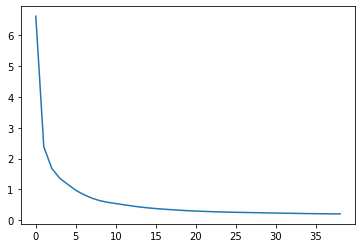

In [ ]:
plt.plot(all_losses)

In [ ]:
show_accuracies(my_cnn, train_images, train_labels, val_images, val_labels, test_images, test_labels, W, B)

Accuracies :
    - train accuracy = 95.45166666666667 %
    - val accuracy = 94.62 %
    - test accuracy = 93.89999999999999 %
